# Import necessary libraries

In [1]:
import os
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import numpy as np
import pandas as pd
import cv2

# Load dataset

In [2]:
train_path = '/kaggle/input/airbus-ship-detection/train_v2'
train_segmentation_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'

train_segmentations = pd.read_csv(train_segmentation_path)
train_segmentations.shape

(231723, 2)

In [3]:
print(train_segmentations['EncodedPixels'][24])
train_segmentations.head()

458957 14 459725 14 460493 14 461261 14 462029 14 462797 14 463565 14


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
print('isnull:\n', train_segmentations.isnull().sum())
print('isna:\n',  train_segmentations.isna().sum())

isnull:
 ImageId               0
EncodedPixels    150000
dtype: int64
isna:
 ImageId               0
EncodedPixels    150000
dtype: int64


In [5]:
train_segmentations.nunique() # id -> pixels is not 'onto' mapping wtf?

ImageId          192556
EncodedPixels     81722
dtype: int64

# Data Description
EncodedPixels - a list of pixels for ship segmentation in a compressed format (in run-length encoding format) (RLE).

EncodedPixels сonsists of pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

A prediction of of "no ship in image" have a blank value in the EncodedPixels column.

Object segments do not overlap.

# Some useful functions

In [6]:
def rle_decode(mask_rle, shape=(768, 768)) -> np.array:
    """
    decode run-length encoded segmentation mask
    Assumed all images aRe 768x768 (and ThereforE have the saMe shape)
    """
    
    # if no segmentation mask (nan) return matrix of zeros
    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    # RLE sequence str split to and map to int
    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # indices: 2k - starts, 2k+1 lengths
    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T

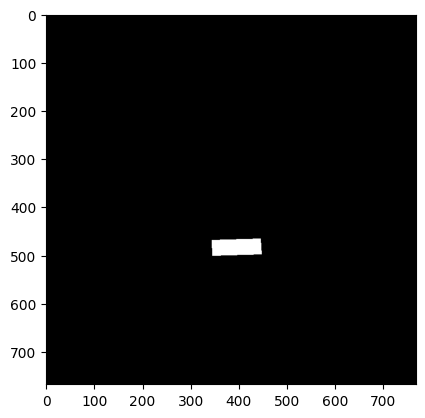

In [7]:
some_image_mask = rle_decode(train_segmentations['EncodedPixels'][2])
plt.imshow(some_image_mask, cmap='gray')

In [8]:
def plot_image_with_mask(df: pd.DataFrame, index: int) -> None:
    fig, ax = plt.subplots(ncols=2)
    
    img_name = df['ImageId'][index]
    img_rle_seqs = df.loc[df['ImageId'] == img_name]['EncodedPixels']  # get rle seqence for each object on the image
    
    img = cv2.imread(os.path.join(
        '/kaggle/input/airbus-ship-detection/train_v2', img_name))
    
    # sum masks of all objects
    img_mask = np.zeros((768, 768), dtype=np.uint8)
    
    for rle in img_rle_seqs:
        img_mask += rle_decode(rle)
    
    plt.grid(False)
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[1].imshow(img_mask, cmap='gray')
    plt.tight_layout()
    plt.show()

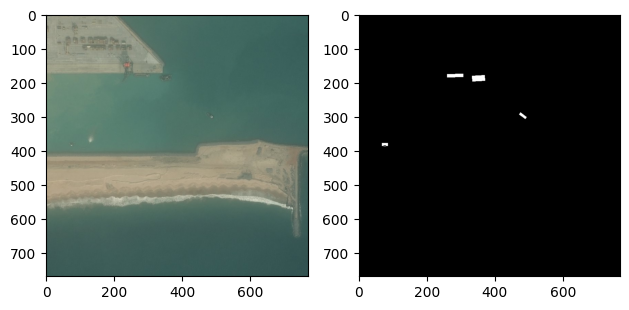

In [9]:
# plot_image_with_mask(train_segmentations, 666)
plot_image_with_mask(train_segmentations, 3)

# Exploratory Data Analysis

In [10]:
ship_count_by_id = train_segmentations\
    .groupby('ImageId', as_index=False)\
    .count()\
    .rename(columns={'EncodedPixels': 'nObjects'})

ship_counts = ship_count_by_id\
    .groupby('nObjects', as_index=False)\
    .count()\
    .rename(columns={'ImageId': 'nCounts'})

In [11]:
ship_count_by_id.head()

,ImageId,nObjects
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0


In [12]:
ship_counts.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
nObjects,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
nCounts,150000,27104,7674,2954,1622,925,657,406,318,243,168,144,124,75,76,66


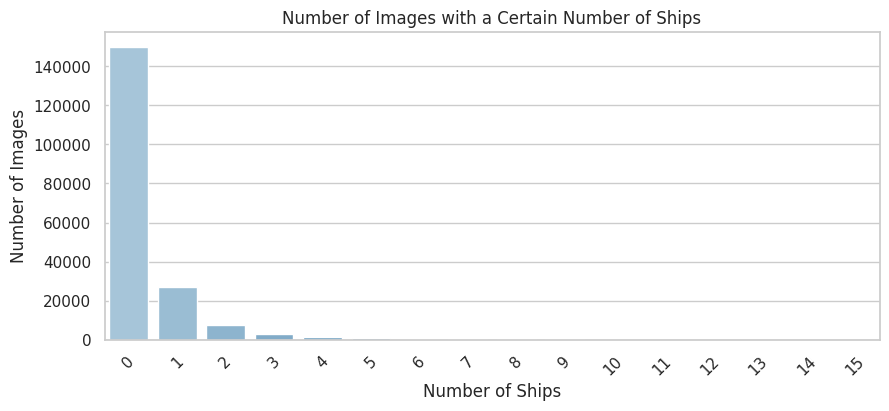

In [13]:
# plot all numbers of images with certain amount of ships on them

sns.set(style="whitegrid")

plt.figure(figsize=(10, 4))
sns.barplot(x='nObjects', y='nCounts', data=ship_counts, palette='Blues_d')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.title('Number of Images with a Certain Number of Ships')
plt.xticks(rotation=45)
plt.show()

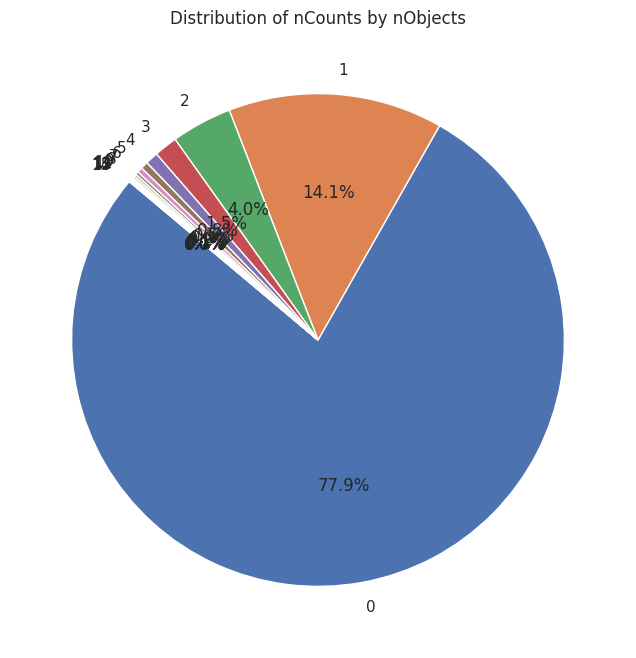

In [23]:
plt.figure(figsize=(8, 8))
plt.pie(ship_counts['nCounts'], labels=ship_counts['nObjects'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of nCounts by nObjects')
plt.show()

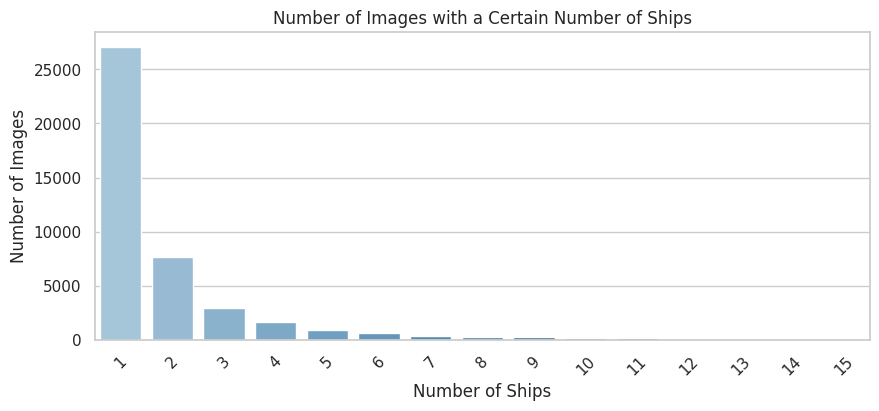

In [15]:
# the same as preveious but exclude no-ship images

plt.figure(figsize=(10, 4))
sns.barplot(x='nObjects', y='nCounts', data=ship_counts[1:], palette='Blues_d')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.title('Number of Images with a Certain Number of Ships')
plt.xticks(rotation=45)
plt.show()

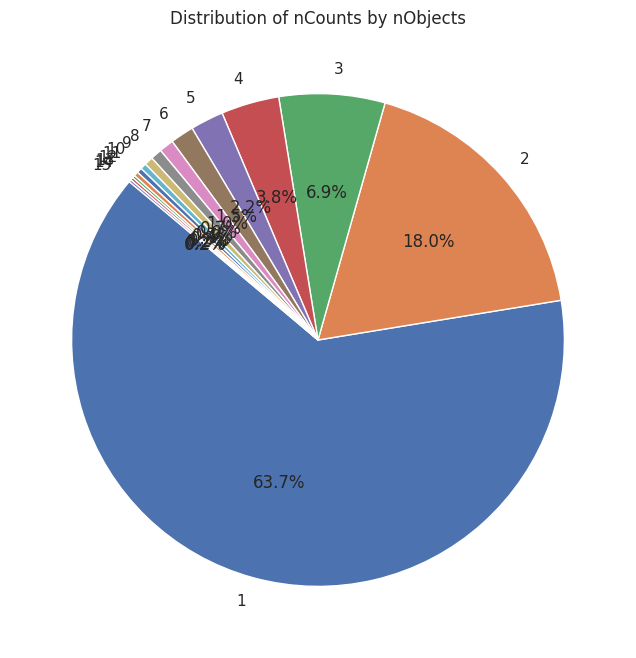

In [22]:
plt.figure(figsize=(8, 8))
plt.pie(ship_counts[1:]['nCounts'], labels=ship_counts[1:]['nObjects'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of nCounts by nObjects')
plt.show()

In [18]:
train_segmentations

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [24]:
import os
import random
import glob
import gc  # garbage collector

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import cv2
# import albumentations as A  # for image data augmentation

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, Input, MaxPooling2D, 
                                     Dropout, concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

# pytorch
# import torch
# import torch.nn as nn
# import torch.functional as F

import warnings
warnings.filterwarnings('ignore')

In [26]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Please ensure CUDA and cuDNN are properly installed.")

1 Physical GPUs, 1 Logical GPUs


In [28]:
FULL_SHAPE = (768, 768)
# NEW_SHAPE = (256, 256)
NEW_SHAPE = (128, 128)

In [29]:
def rle_decode(mask_rle, shape=(768, 768)) -> np.array:
    """
    decode run-length encoded segmentation mask
    Assumed all images aRe 768x768 (and ThereforE have the saMe shape)
    """
    
    # if no segmentation mask (nan) return matrix of zeros
    if not mask_rle or pd.isna(mask_rle):
        return np.zeros(shape, dtype=np.uint8)

    # RLE sequence str split to and map to int
    s = list(map(int, mask_rle.split()))

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    # indices: 2k - starts, 2k+1 lengths
    starts, lengths = s[0::2], s[1::2]
    for start, length in zip(starts, lengths):
        img[start:start + length] = 1

    return img.reshape(shape).T

In [30]:
def rle_encode():
    return

In [31]:
def dice_coeff(y_true, y_pred, smooth=1.0):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def BCE_dice(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) + (1 - dice_coeff(y_true, y_pred))

In [32]:
def create_dataset(image_dir: str, image_filenames: list[str], image_masks: pd.DataFrame) -> tuple:
    # for each image filename
    # read original image using cv2
    # compute segmentations using RLE from image_masks dataframe
    # append each to tensorflow tensor or smth
    
    images = []
    masks = []
    
    for i, image_filename in enumerate(image_filenames):
        image_path = f"{image_dir}/{image_filename}"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        image = cv2.resize(image, NEW_SHAPE)
        
        # get RLE sequences for current image
        mask_rles = image_masks[image_masks['ImageId'] == image_filename]['EncodedPixels']
        mask = np.zeros(FULL_SHAPE, dtype=np.uint8)  # init empty mask

        for rle in mask_rles:
            mask += rle_decode(rle)
        
        mask = cv2.resize(mask, NEW_SHAPE)
        image = image / 255.0

        images.append(image)
        masks.append(mask)

    images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
    masks_tensor = tf.convert_to_tensor(masks, dtype=tf.uint8)

    return images_tensor, masks_tensor

In [33]:
train_folder_path = '/kaggle/input/airbus-ship-detection/train_v2'
train_masks_path = '/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv'
test_folder_path = '/kaggle/input/airbus-ship-detection/test_v2'

In [34]:
train_masks_df = pd.read_csv(train_masks_path)

In [35]:
class ShipDatasetModified(keras.utils.Sequence):
    
    def __init__(self, image_dir, image_filenames, image_size=(256, 256), batch_size=128):
        # data loader params
        self.image_size = image_size
        self.batch_size = batch_size
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        # read run-length encoded ships
        self.image_masks_df = pd.read_csv(train_masks_path)
    
    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index: Index of the batch
        :return: Batch of images and masks
        """
        # create batch indices
        batch_indices = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        
        # create arrays for images and masks
        batch_images = np.zeros((self.batch_size, *self.image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((self.batch_size, *self.image_size, 1), dtype=np.uint8)
        
        for i, current_image_name in enumerate(batch_indices):
            try:
                # read image and convert to rgb
                image = cv2.imread(os.path.join(self.image_dir, current_image_name))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # get segmentation mask using image filename
                img_rle_seqs = self.image_masks_df.loc[self.image_masks_df['ImageId'] == current_image_name]['EncodedPixels']
                image_mask = np.zeros(FULL_SHAPE, dtype=np.uint8)  # empty mask
                
                for rle in img_rle_seqs:
                    image_mask += rle_decode(rle)
                
                # resize img and its mask
                image = cv2.resize(image, self.image_size)
                image_mask = cv2.resize(image_mask, self.image_size)
                
                image = image / 255.0  # Normalize to [0, 1]
                
                batch_images[i] = image
                batch_masks[i] = np.expand_dims(image_mask, axis=-1)
                
            except Exception as e:
                print(f"Error processing image {current_image_name}: {e}")
        
        return batch_images, batch_masks

    def on_epoch_end(self):
        """
        Updates indices after each epoch
        """
        # shuffle inplace after last batch in epoch
        random.shuffle(self.image_filenames)

    def _load_image(self, image_path):
        """
        Load and preprocess an image
        :param image_path: Path to the image
        :return: Preprocessed image array
        """
        # Load and preprocess an image
        pass

In [36]:
image_filenames = [os.path.basename(filename) for filename in glob.glob(train_folder_path + '/*')]
# random.Random(42).shuffle(image_filenames)
print(image_filenames[:10])
ratio = .8
split_index = int(ratio * len(image_filenames))
train_filenames, val_filenames = image_filenames[: split_index], image_filenames[split_index:]

train_ship_dataset = ShipDatasetModified(train_folder_path, train_filenames)
val_ship_dataset = ShipDatasetModified(train_folder_path, val_filenames)

len(train_ship_dataset), len(val_ship_dataset)



['d8bc90fd6.jpg', 'ee783cf9f.jpg', '4b0d96146.jpg', '7c8d78c3f.jpg', '290f37d66.jpg', '6a91a5706.jpg', '43fa8864a.jpg', '018c1ff4d.jpg', 'a93de8732.jpg', 'e97cb9839.jpg']


(154044, 38512)

In [37]:
train_ship_dataset[0][0].shape

(128, 256, 256, 3)

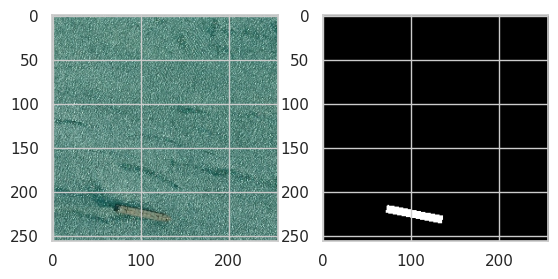

In [38]:
i = 6
some_image, some_mask = train_ship_dataset[0]
some_image = some_image[i]
some_mask = some_mask[i]

fig, ax = plt.subplots(ncols=2)

ax[0].imshow(some_image)
ax[1].imshow(some_mask, cmap='gray')
plt.show()



In [39]:
random.Random(42).shuffle(image_filenames)
train_filenames, val_filenames = image_filenames[: split_index], image_filenames[split_index:]

# random.Random(42).shuffle(train_filenames)
# random.Random(42).shuffle(val_filenames)

# get slice of whole data (i dont want to transform images and compute masks every time i get an dataset item)
train_filenames = train_filenames[:9000]
val_filenames = val_filenames[:1000]

# remove images which does not contain any ships (later)

print(len(train_filenames), len(val_filenames))

gc.collect()

9000 1000


125

In [40]:
X_train, y_train = create_dataset(train_folder_path, train_filenames, train_masks_df)
X_val, y_val = create_dataset(train_folder_path, val_filenames, train_masks_df)

In [41]:
X_train.shape, y_train.shape

(TensorShape([9000, 128, 128, 3]), TensorShape([9000, 128, 128]))

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# train_dataset_iterator = train_dataset.as_numpy_iterator()
# val_dataset_iterator = val_dataset.as_numpy_iterator()

batch_size = 64
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)  # no need to shuffle validation data

In [43]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

In [44]:
X_train = tf.convert_to_tensor(np.load('X_train.npy'))
y_train = tf.convert_to_tensor(np.load('y_train.npy'))
X_val = tf.convert_to_tensor(np.load('X_val.npy'))
y_val = tf.convert_to_tensor(np.load('y_val.npy'))

In [45]:
X_train.shape, y_train.shape

(TensorShape([9000, 128, 128, 3]), TensorShape([9000, 128, 128]))

In [46]:
def create_conv2d_block(input_tensor, num_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    
    # 1st layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
        
    x = keras.layers.Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    
    return x

In [47]:
def create_unet(input_shape, num_filters=16, dropout=0.1, batchnorm=True):
    """
    Function to define the UNET Model
    input_shape: (height, width, 3)
    """
    
    assert input_shape[-1] == 3  # image must have 3 channels
    
    # input 'layer'
    #input_img = Input((*input_shape, 3), name='img')
    input_img = Input(input_shape, name='img')
    
    # downsampling (encoder)
    c1 = create_conv2d_block(input_img, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = create_conv2d_block(p1, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = create_conv2d_block(p2, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = create_conv2d_block(p3, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck
    c5 = create_conv2d_block(p4, num_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling (decoder)
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = create_conv2d_block(u6, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = create_conv2d_block(u7, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = create_conv2d_block(u8, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = create_conv2d_block(u9, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [48]:
input_shape = (*NEW_SHAPE, 3)

unet_model = create_unet(input_shape)

metrics = [
    'accuracy',
    dice_coeff,
    dice_loss,
]

# unet_model.compile(optimizer=Adam(0.0005), loss="binary_crossentropy", metrics=metrics)
unet_model.compile(optimizer=Adam(0.0005), loss=BCE_dice, metrics=metrics)

gc.collect()

0

In [49]:
unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │            448 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 16)     │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 32)     │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 32)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 32)     │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_5     │ (None, 32, 32, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_5 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ activation_5[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 64)     │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)    

 Total params: 1,179,409 (4.50 MB)

 Trainable params: 1,177,937 (4.49 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [50]:
callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir='./logs')
]

In [51]:


history = unet_model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9478 - dice_coeff: 0.0024 - dice_loss: 0.9976 - loss: 1.3691
Epoch 1: val_loss improved from inf to 1.19590, saving model to model-Unet.weights.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 157ms/step - accuracy: 0.9481 - dice_coeff: 0.0024 - dice_loss: 0.9976 - loss: 1.3684 - val_accuracy: 0.9987 - val_dice_coeff: 0.0027 - val_dice_loss: 0.9973 - val_loss: 1.1959
Epoch 2/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9986 - dice_coeff: 0.0030 - dice_loss: 0.9970 - loss: 1.1386
Epoch 2: val_loss improved from 1.19590 to 1.08546, saving model to model-Unet.weights.h5
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9987 - dice_coeff: 0.0030 - dice_loss: 0.9970 - loss: 1.1384 - val_accuracy: 0.9988 - val_dice_coeff: 0.0037 - val_dice_loss: 0.9963 - val_loss: 1.0855
Epoch 3/20
140/141 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9989 - dice_coeff: 0.0046 - dice_loss: 0.9954 - loss: 1.0809
Epoch 3: val_loss imp

In [52]:
import pickle

with open('unet_history.obj', 'wb') as f:
    pickle.dump(history.history, f)

unet_model.save_weights('winstarsai_airbus_unet.weights.h5')

In [53]:
def plot_training_history(history):
    # Extract the history data
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    dice_coeff = history.history['dice_coeff']
    val_dice_coeff = history.history['val_dice_coeff']

    epochs = range(1, len(accuracy) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice coefficient
    plt.subplot(1, 3, 3)
    plt.plot(epochs, dice_coeff, 'go', label='Training Dice Coefficient')
    plt.plot(epochs, val_dice_coeff, 'g', label='Validation Dice Coefficient')
    plt.title('Training and validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

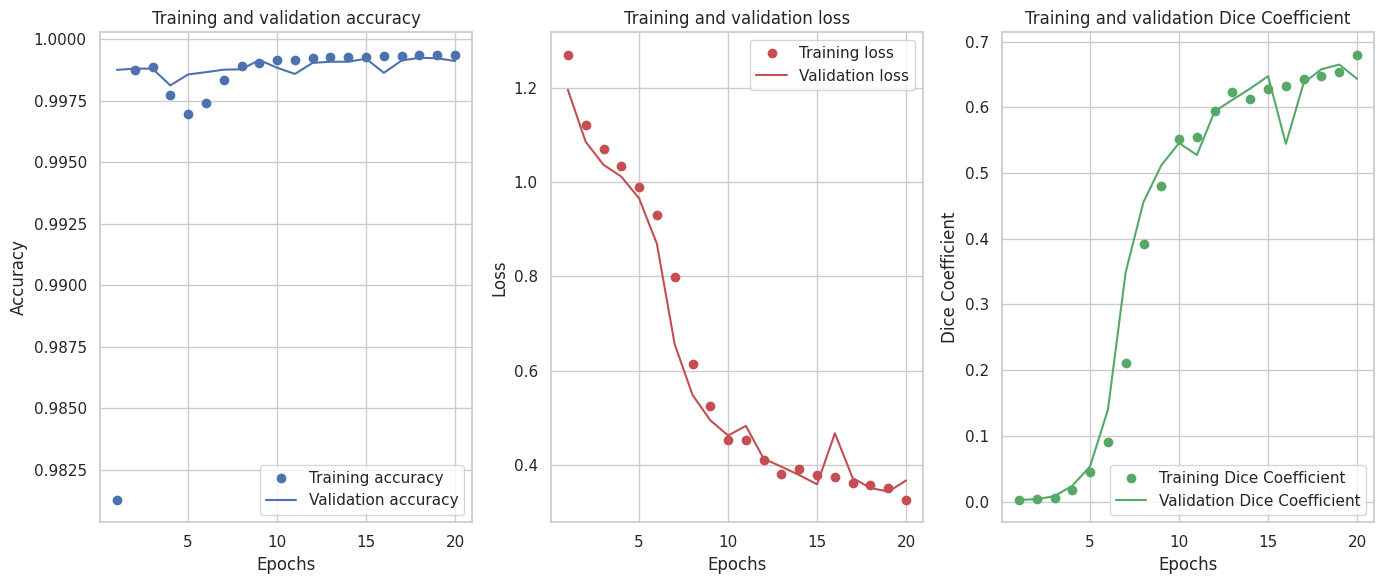

In [54]:
plot_training_history(history)

In [55]:
import os
import random
import glob
import gc  # garbage collector

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import cv2

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, Input, MaxPooling2D, 
                                     Dropout, concatenate, UpSampling2D, BatchNormalization, Conv2DTranspose)
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

In [56]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs found. Please ensure CUDA and cuDNN are properly installed.")

1 Physical GPUs, 1 Logical GPUs


In [57]:
FULL_SHAPE = (768, 768)
NEW_SHAPE = (128, 128)

In [58]:
def image_from_path(img_dir, img_name):
    
    img_path = os.path.join(img_dir, img_name)
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, NEW_SHAPE)
    image = image / 255.0  # Normalize to [0, 1]
    
    return np.expand_dims(image, axis=0)

In [59]:
def create_conv2d_block(input_tensor, num_filters, kernel_size=3, batchnorm=True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    
    # 1st layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
        
    x = keras.layers.Activation('relu')(x)
    
    # 2nd layer
    x = Conv2D(filters = num_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    
    x = keras.layers.Activation('relu')(x)
    
    return x

In [60]:
def create_unet(input_shape, num_filters=16, dropout=0.1, batchnorm=True):
    """
    Function to define the UNET Model
    input_shape: (height, width, 3)
    """
    
    assert input_shape[-1] == 3  # image must have 3 channels
    
    # input 'layer'
    #input_img = Input((*input_shape, 3), name='img')
    input_img = Input(input_shape, name='img')
    
    # downsampling (encoder)
    c1 = create_conv2d_block(input_img, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = create_conv2d_block(p1, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = create_conv2d_block(p2, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = create_conv2d_block(p3, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    # bottleneck
    c5 = create_conv2d_block(p4, num_filters * 16, kernel_size=3, batchnorm=batchnorm)
    
    # upsampling (decoder)
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = create_conv2d_block(u6, num_filters * 8, kernel_size=3, batchnorm=batchnorm)
    
    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = create_conv2d_block(u7, num_filters * 4, kernel_size=3, batchnorm=batchnorm)
    
    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = create_conv2d_block(u8, num_filters * 2, kernel_size=3, batchnorm=batchnorm)
    
    u9 = Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = create_conv2d_block(u9, num_filters * 1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [62]:
input_shape = (*NEW_SHAPE, 3)
unet_weights_path = '/kaggle/input/ship_detection_unet/tensorflow2/v1/1/model-Unet.weights.h5'

unet_model = create_unet(input_shape)
unet_model.load_weights(unet_weights_path)

In [63]:
test_images_folder_path = '/kaggle/input/airbus-ship-detection/test_v2'
test_images_filenames =  [os.path.basename(filename) for filename in glob.glob(test_images_folder_path + '/*')]

In [64]:
len(test_images_filenames), test_images_filenames[:10]

(15606,
 ['4291f3a66.jpg',
  'b0808caaf.jpg',
  '9f582d5ce.jpg',
  '916ae8dd3.jpg',
  '6fa533973.jpg',
  'e0cf877a8.jpg',
  '5e5085535.jpg',
  '51ffc3d65.jpg',
  '6dce1205c.jpg',
  'b0c08f452.jpg'])

In [82]:
some_image = image_from_path(test_images_folder_path, test_images_filenames[10])
some_image.shape

(1, 128, 128, 3)

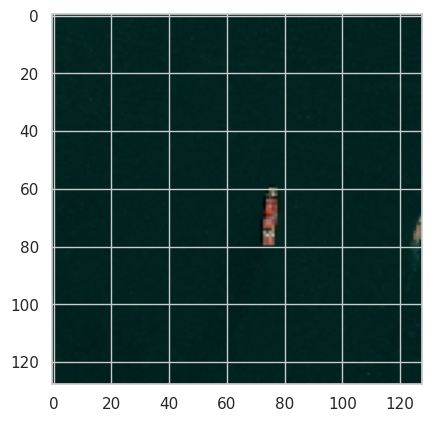

In [83]:
plt.imshow(some_image.squeeze(axis=0))
plt.show()

In [84]:
def make_prediction(model, image):
    threshold = 0.5
    
    # get probability for each pixel (-> np.ndarray)
    prob_mask = model.predict(image).squeeze(0)
    
    segmentation_mask = np.zeros(prob_mask.shape)
    # Convert probabilities to binary segmentation mask
    segmentation_mask = (prob_mask > threshold).astype(np.uint8)
    return segmentation_mask

In [85]:
some_image_mask = make_prediction(unet_model, some_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


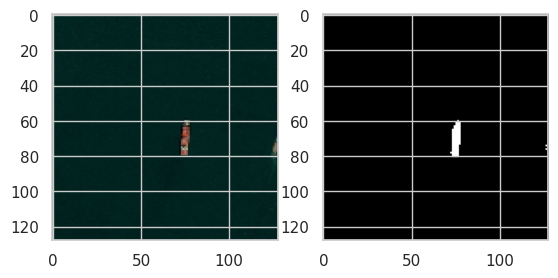

In [86]:
fig, ax = plt.subplots(ncols=2)

ax[0].imshow(some_image.squeeze(0))
ax[1].imshow(some_image_mask, cmap='gray')
plt.show()